# POA Using PVLIB Irradiance Transposition Model Functions Evaluated Against Measured POA from Pyranometer

In [1]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import datatools
import datetime
import pvlib
import math
import statistics

from sklearn.metrics import mean_squared_error
from math import sqrt

#Set plotting format
%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=1)

In [68]:
#read in previously generated data

#input file names : 'irr_inputs_112021.csv' & 'irr_inputs_052021.csv'
inputs = pd.read_csv('irr_inputs_052021.csv')
inputs.index = inputs.TmStamp
inputs.index = pd.to_datetime(inputs.index)

#Creating a df with the measured data to add the results of the models to
#Adding measured poa to df
poa_global = inputs['Measured POA'].to_frame()

In [69]:
#Defining constants and values that are consistent across all calculations
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180}
module = pd.Series(module)

aoi = pvlib.irradiance.aoi(surface_tilt = module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                           solar_zenith = inputs['sol_zen'], solar_azimuth=inputs['sol_azi'])
ground_diffuse = inputs['GHI'] * inputs['albedo'] * (1 - np.cos(np.radians(module['Tilt']))) * 0.5
poa_direct = (inputs['DNI'] * np.cos(np.radians(aoi)))
poa_direct[poa_direct < 0] = 0

In [70]:
#isotropic model
sky_diffuse = pvlib.irradiance.isotropic(surface_tilt = module['Tilt'], dhi=inputs['DHI'])
poa_diffuse = sky_diffuse + ground_diffuse
poa_global['Isotropic'] = (poa_diffuse + poa_direct)

In [71]:
#perez model
sky_diffuse = pvlib.irradiance.perez(surface_tilt = module['Tilt'], surface_azimuth=module['Surface Azimuth'],
                dhi=inputs['DHI'],dni=inputs['DNI'], dni_extra=inputs['DNI_extra'], solar_zenith=inputs['sol_zen'], 
                solar_azimuth=inputs['sol_azi'], airmass=inputs['airmass'])
poa_diffuse = sky_diffuse + ground_diffuse
poa_global['Perez'] = (poa_diffuse + poa_direct)

In [72]:
#haydavies
sky_diffuse = pvlib.irradiance.haydavies(surface_tilt = module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                        dhi=inputs['DHI'], dni=inputs['DNI'], dni_extra=inputs['DNI_extra'], 
                        solar_zenith= inputs['sol_zen'], solar_azimuth=inputs['sol_azi'])
poa_diffuse = sky_diffuse + ground_diffuse
poa_global['Haydavies'] = (poa_diffuse + poa_direct)

In [73]:
#klucher
sky_diffuse = pvlib.irradiance.klucher(surface_tilt = module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                dhi=inputs['DHI'], ghi=inputs['GHI'], solar_zenith= inputs['sol_zen'], solar_azimuth=inputs['sol_azi'])
poa_diffuse = sky_diffuse + ground_diffuse
poa_global['Klucher'] = (poa_diffuse + poa_direct)

In [74]:
#reindl
sky_diffuse = pvlib.irradiance.reindl(surface_tilt = module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
                dhi=inputs['DHI'], dni=inputs['DNI'], ghi=inputs['GHI'], dni_extra=inputs['DNI_extra'], 
                solar_zenith= inputs['sol_zen'], solar_azimuth=inputs['sol_azi'])
poa_diffuse = sky_diffuse + ground_diffuse
poa_global['Reindl'] = (poa_diffuse + poa_direct)

In [75]:
#king
sky_diffuse = pvlib.irradiance.king(surface_tilt = module['Tilt'],dhi=inputs['DHI'],
                                    ghi=inputs['GHI'],solar_zenith=inputs['sol_zen'])
poa_diffuse = sky_diffuse + ground_diffuse
poa_global['King'] = (poa_diffuse + poa_direct)

#### Calculating & Visualizing Error

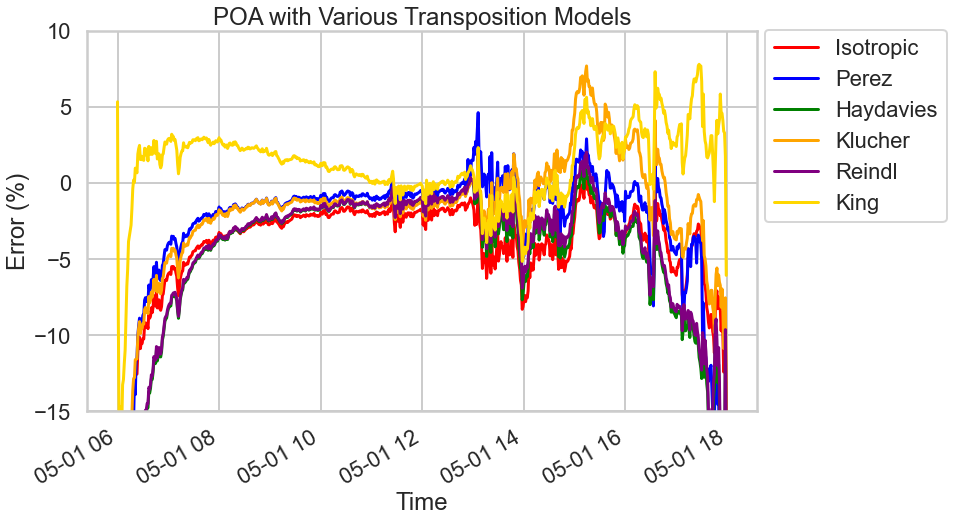

In [84]:
#Calculating % Error 
models = ['Isotropic','Perez','Haydavies', 'Klucher','Reindl','King']
for model in models:
    poa_global['Error - ' + model] = 100*((poa_global[model] - poa_global['Measured POA'])/(poa_global['Measured POA']))
    
#Plotting the % Error of the Transposition Models 

x = poa_global.index
y = poa_global['Error - Isotropic']
plt.plot(x, y, 'red')
y = poa_global['Error - Perez']
plt.plot(x, y, 'blue')
y = poa_global['Error - Haydavies']
plt.plot(x, y, 'green')
y = poa_global['Error - Klucher']
plt.plot(x, y, 'orange')
y = poa_global.['Error - Reindl']
plt.plot(x, y, 'purple')
y = poa_global['Error - King']
plt.plot(x, y, 'gold')


plt.xlim('2021-05-01 00:00:00-0700','2021-05-02 00:00:00-0700')
plt.ylim(-15,10)
plt.ylabel('Error (%)')
plt.xlabel('Time')
plt.xticks(rotation=30, ha='right')
plt.title('POA with Various Transposition Models')
plt.legend(['Isotropic','Perez','Haydavies', 'Klucher','Reindl','King'],loc='center right', bbox_to_anchor=(1.3, 0.75))

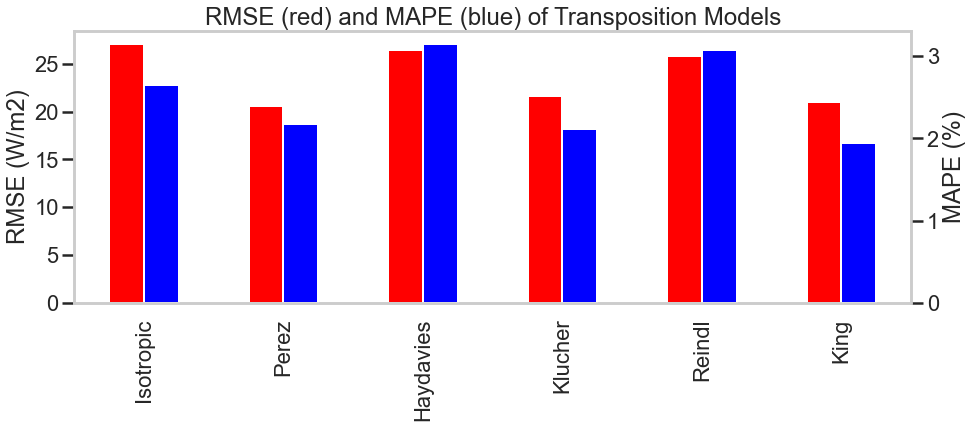

In [85]:
#Calculating RMSE/MAPE/
#need a df with no NaNs first
rmse = []
nandrop_poa_global = poa_global.dropna()
for model in models:
    rmserror = sqrt(mean_squared_error(nandrop_poa_global['Measured POA'],nandrop_poa_global[model]))
    rmse.append(rmserror)
    
model_res = pd.DataFrame(rmse, index=models)
model_res.rename(columns = {0 : 'RMSE'}, inplace = True)

mape =[]
for model in models:
    maperror = (abs(poa_global['Error - ' + model])).sum()/(len(poa_global['Error - ' + model]))
    mape.append(maperror)
model_res['MAPE'] = mape


#plotting
model_res.plot.bar(figsize=(15,5), secondary_y= 'MAPE', color=['red','blue'])
plt.grid(False)
plt.title('RMSE (red) and MAPE (blue) of Transposition Models')
ax1, ax2 = plt.gcf().get_axes() # gets the current figure and then the axes
ax1.set_ylabel('RMSE (W/m2)')
#ax1.set_ylim(0,35)
ax2.set_ylabel('MAPE (%)')
ax1.get_legend().remove()
#ax2.set_ylim(0,4)